# Generating sounds via Python

Python is maybe not the programming language of choice when creating sounds because it is a language which executes one thing at a time (and therefore makes it hard to playback sound while calculating a pattern in the meantime) but for this chapter we want to explore the possibilities of audio synthesis with Python using numpy.

To generate an digital audio signal from the ground gives us also the possibility to recap the understanding of digital signal processing step by step.

A recommenden read and watch on this topic are [A Digital Media Primer For Geeks](https://wiki.xiph.org/Videos/A_Digital_Media_Primer_For_Geeks) and [Digital Show & Tell](https://wiki.xiph.org/Videos/Digital_Show_and_Tell), both by the excellent [xiph.org](https://xiph.org/) foundation.

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import soundfile
from IPython.display import display, Audio

mpl.rcParams['figure.figsize'] = (10, 3)

## The canvas of an audio file

The most common way to store audio signals in a digital way is [PCM](https://en.wikipedia.org/wiki/Pulse-code_modulation) which stores at each point of time the amplitude of the signal.
But we need to refine the term *point of time* here.
In the real world signals are continuous - but representing a continious signal in a memory limited and *binary thinking* computer is impossible why we need to introduce quantisation of our signal.

![PCM encoded signal - [Source](https://commons.wikimedia.org/wiki/File:Pcm.svg)](https://upload.wikimedia.org/wikipedia/commons/b/bf/Pcm.svg)

### Amplitude quantisation

PCM quantizes the time and the amplitude domain where each fraction of time is stored as a position in a list.
The amplitude $a_i$ at a timestep $i$ is encoded as an integer or a float.
For both we can use different bit sizes to control the precission of our amplitude quantisation.
CDs use 16 bit integer which result in $2^{16}=65'536$ distinct values of amplitude.
But as an amplitude can be positive and negative this should be accounted and so instead of an unsigned 16 bit integer which covers the numbers from $0$ to $65'535$ we use a signed 16 bit integer which maps the same $65'536$ possible bit combinations from $−32'768$ to $+32'767$.

The difference of the original continous signal and the same signal represented in $65'536$ discrete steps of amplitude gives us the quantization error (also called quantisation noise).
Using an analog to digital converter (*ADC*) we can represent an audio range of $96.33~\text{dB}$ until the quantisation noise is louder than our signal (called noise floor or signal to noise ration (*SNR*)) while using 16 bit, see [audio bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth#Quantization).

As we now have a restricted range of our amplitude values, it is not possible to exceed this boundary as every value that does not fit into this restriction gets [clipped](https://en.wikipedia.org/wiki/Clipping_(audio)) which results in distortion of our signal.
One countermeasure is to work with [floating point precision](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) numbers instead, but this forces us to use a higher resolution - 32 and 64 bit are common - resulting in 2 or 4 times the amount of data compared to a 16 bit integer signal.
Have in mind that this does not just consume more memory but it also takes more time to compute.

### Time quantisation

As we also have to quantise the time domain we need to think about what kind of resolution is necessary to find a good compromise between digital resources and human perception.
Thankfully there is the [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) which tells us the necessary resolution of our time domain, also called *bandwith*, to accurately represent a frequency.
The theorem tells us that we can represent any frequency $f$ in our signal accurately if the length of the block of time (also called bandwith) has at least the length of $2f$ where the unit of a frequncy is $1 \text{Hz} = \frac{1}{\text{sec}}$.
In this case $f$ is als known as the [Nyquist rate](https://en.wikipedia.org/wiki/Nyquist_rate) and we refer to $2f$ as the *sampling rate*.

Doing a hearing test tells us that our perception of sine waves already declines at around $8'000~\text{Hz}$ sine and fades away completely between $14'000$ and $20'000~\text{Hz}$ which is different for each person due to anatomy.
Additionally the *Fletcher Munson curve* tells us an approximation of our sensitivity on frequencies as this is not linear.

![Fletcher-Munson curve - [Source](https://commons.wikimedia.org/wiki/File:Lindos4.svg)](https://upload.wikimedia.org/wikipedia/commons/4/49/Lindos4.svg)

To represent a signal of up to $f=20'000~\text{Hz}$ the Nyquist rate tells us that we need a samplerate of at least $2f=40'000~\text{Hz}=0.000025~\text{sec}$.
One thing we omitted from the Nyquist theorem is that this only works if we work on a bandwith limited signal meaning that no frequency above our Nyquist rate is present in our signal.
We can use a [filter](https://en.wikipedia.org/wiki/Electronic_filter) in front of our ADC to filter out too high frequencies but this filter can not cut hard at a specific frequency without introducing unwanted aliasing which is why we add an additional buffer of frequencies so the frequency rolloff can be applied more gentle.

Of course there are applications where a higher resolution of time (samplerate) is relevant.
If we want to capture ultrasonics we are dependent on a higher sampling rate which can be also transferred down to human perceivable frequencies by changing the playback sample rate $f_p$ to a lower frequency.
If the original material had a sampling rate of $f_o$ the playback speed relative to the originally recorded material is simply $\frac{f_p}{f_o}=s$ where all frequencies are divided by the factor $s$.

At the end we can understand why the CD has 16 bits for the quantisation of amplitude and a sampling rate of $44'1000~\text{Hz}$ to represent a PCM encoded signal as this reflects the limits of our hearing pretty accurate while still stick to the constraints of early 1980s electronics.

## Audio signal synthesis via numpy

After we have briefly discussed the theory behind representing audio signals in the digital domain we can implement this in Python now.
Although most modern software work intenally with a 32 or 64 bit depth we will settle for PCM with a bit depth of 16 bit and a sample rate of $48'000~\text{Hz}$ because it is easier to understand the amplitude precision via integers.

In [ ]:
BIT_RATE = 16
SAMPLING_RATE = 48000
MAX_AMP = (2**BIT_RATE/2)-1

As an audio signal depends on an orientation in time we will now create a enumerated timeline where each quantised step represents $\frac{1}{48'000~\text{Hz}} \approx 0.00002~\text{sec}$.
We will create a timeline of 2 seconds, so $2*48'000=96'000$ steps which could be seen as the ticks of our clock which ticks $48'000$ times per second.

In [ ]:
clock_ticks = np.arange(start=0, stop=SAMPLING_RATE*2, step=1, dtype=np.int)
clock_ticks

array([    0,     1,     2, ..., 95997, 95998, 95999])

We can now use this progressing time to calculate the position of a sine wave at each of our steps.
But first we need to check on an important property of sine, its periodity.

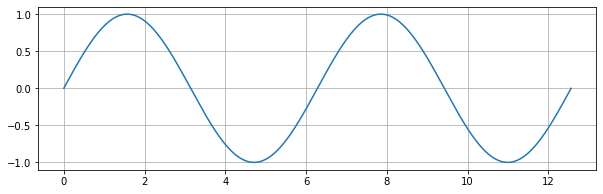

In [ ]:
x = np.arange(0, 4*np.pi, 1/1000)
plt.plot(x, np.sin(x))
plt.grid()
plt.show();

Sine has a period of $2 \pi$, meaning that it repeats its output after multitudes of $2 \pi$.
As we want to create a sine wave which repeats 440 times a second $\left( 440~\text{Hz} = 440 \frac{1}{\text{sec}} \right)$ we need to take account the periodicity of sine as we need to scale it to our ticking clock, the samplerate.

As a second is represented through $48'000$ steps due to our sampling rate we need to scale 440 times per second by our representation of our time

$$
\sin_{440}(x) = \sin \left( \frac{440~\text{Hz}}{48'000~\text{Hz}} 2 \pi x \right) \approx \sin \left( 0.00917 * 2 \pi  x \right)
$$

where $x$ are the incrementing ticks of our clock which runs at $48'000~\text{Hz}$.

We scale the amplitude of our signal by the bit depth we have choosen and can transfer the formula above to the following code.

In [ ]:
sine_signal = (np.sin((2*np.pi*440/SAMPLING_RATE)*clock_ticks)*MAX_AMP).astype(np.int16)
sine_signal

array([    0,  1886,  3766, ..., -5633, -3766, -1886], dtype=int16)

We will write a small convenience function for plotting signals.

In [ ]:
def plot_signal(signal: np.ndarray, steps: int = SAMPLING_RATE/20):
    plt.plot(np.arange(0, len(signal), 1), signal)
    if steps:
        plt.xlim(0, steps)
    plt.hlines(0, 0, len(signal), color='red')
    plt.show();

Now we can take a look at our just generated signal.

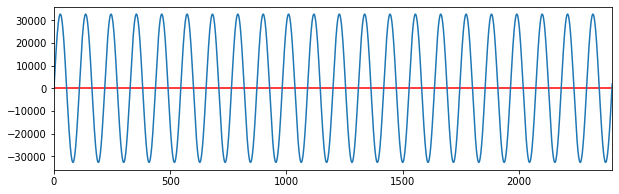

In [ ]:
plot_signal(sine_signal)

### Storing audio data in a file

How a PCM signal is stored in a file is determined by a [container](https://en.wikipedia.org/wiki/Container_format_(computing)) and is different from container to container.
A container can also store metadata (such as title of the file) and store multi-channel audio which is simply encoded as multiple PCM channels.

How to write such a file precisely is out of our scope and can use the library [soundfile](https://github.com/bastibe/python-soundfile) (which itself uses the library [libsndfile](http://www.mega-nerd.com/libsndfile/) to write the files) to hand off this task.

We can use directly listen to the rendered file from within Jupyter and embedd it into our document.

**Pay attention** The file stores a sine wave at maximum level! Lower the levels of your listening device before hitting play!

In [ ]:
soundfile.write(file='sine.wav', data=sine_signal*0.4, samplerate=SAMPLING_RATE, subtype='PCM_16')
display(Audio('sine.wav'))

### Combining multiple sine waves

Most of the time we do not want to limit us to a single sine tone - but already a combination of 2 sine tones can sound more interesting and is also easily written as code using numpy.
For this we will write an function which acts as a sine oscilator.

In [ ]:
def sine_osc(hz: int, amp: float = 1.0, dtype=np.int16) -> np.ndarray:
    return (np.sin((2*np.pi*hz/SAMPLING_RATE)*clock_ticks)*MAX_AMP*amp).astype(dtype)

#### 200 Hz + 440 Hz

Combining a 200 Hz sine wave with a 440 Hz sine wave can be simply written in the following way which reminds a bit of SuperCollider.

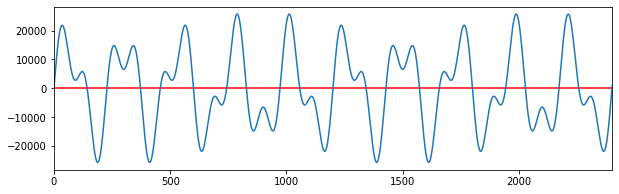

In [ ]:
sine_200 = sine_osc(200, amp=0.5)
sine_440 = sine_osc(440, amp=0.3)

sine_200_440 = sine_440 + sine_200

plot_signal(sine_200_440)

In [ ]:
soundfile.write(file='sine_200_400.wav', data=sine_200_440, samplerate=SAMPLING_RATE, subtype='PCM_16')
display(Audio('sine_200_400.wav'))

### Overtone series

We can also create more complex sounds by layering $n$ sine waves given a base frequency $f_b$ using

$$
\text{signal}(x) = \sum_{i \in \{ 0, \dots n\}} \sin_{\text{f}_i}(x) = \sum_{i \in \{ 0, \dots n\}} \sin_{f_b^{\frac{16+i}{16}}}(x)
$$

where we can use matplotlib to plot the stacked frequencies.

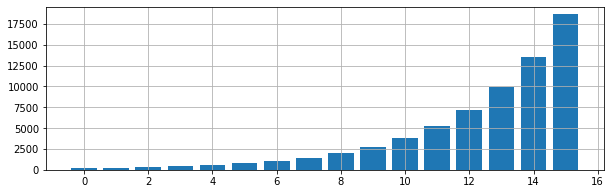

In [ ]:
x = np.arange(0, 16, 1)
plt.bar(x, 160**((16+x)/16));
plt.grid()

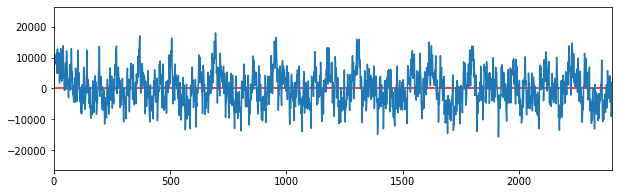

In [ ]:
base_freq = 160
num_steps = 15
sine_comb = np.sum([sine_osc(base_freq**((16+i)/16), amp=1/(num_steps+1)) for i in range(num_steps)], axis=0).astype(np.int16)

plot_signal(sine_comb)

In [ ]:
soundfile.write(file=f'sine_{base_freq}_comb.wav', data=sine_comb, samplerate=SAMPLING_RATE, subtype='PCM_16')
display(Audio(f'sine_{base_freq}_comb.wav'))

#### Frequency swipe

Instead of using a constant scalar for the frequency for our sine oscillator we can also pass it a numpy array with values.

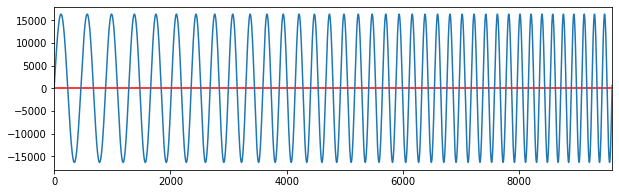

In [ ]:
freq_swipe = np.linspace(100, 1000, num=SAMPLING_RATE*2) # go from 100 to 1000 in 96000 steps
sine_swipe = sine_osc(freq_swipe, amp=0.5)

plot_signal(sine_swipe, steps=9600)

In [ ]:
soundfile.write(file='sine_swipe.wav', data=sine_swipe, samplerate=SAMPLING_RATE, subtype='PCM_16')
display(Audio('sine_swipe.wav'))

Using Python to generate audio signals is possible but also tedious as some basic design choices at the core of Python show why a domain specific language like sclang with its sound engine SuperCollider has advantages such as immediately playback of the signal and change the parameters of the code can be modified while the signal is playing.

Both of these would be really hard if not impossible to implement in Python.
Althogh numpy arrays and [UGens](https://doc.sccode.org/Guides/UGens-and-Synths.html) share some basic principles numpy arrays are not build to work with streaming data - which is a basic idea of SuperCollider and allows us to work in realtime.
Python is nonetheless a good addition to SuperCollider as due its popularity and variety of use cases it fills gaps in SuperCollider and is also a language which focus on readability.